Loading Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import fnmatch
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D,GlobalAveragePooling2D,Input
from tensorflow.keras.utils import to_categorical,normalize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from glob import glob
import cv2
import seaborn as sns

Loading and exploring Data

In [9]:
imagePatches = glob('IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1151_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1201_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1251_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1301_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1351_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1501_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1551_class0.png


In [10]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1001_class0.png', 'IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1051_class0.png', 'IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1101_class0.png', 'IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1151_class0.png', 'IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1201_class0.png'] 

IDC(+)

 ['IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y351_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y401_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y301_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y351_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y401_class1.png']


Creating features and labels

In [11]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [12]:
X,Y = proc_images(0,90000)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1]

Exploring data

In [13]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)



Total number of images: 90000
Number of IDC(-) Images: 64583
Number of IDC(+) Images: 25417
Percentage of positive images: 28.24%
Image shape (Width, Height, Channels): (50, 50, 3)


Plotting image

0


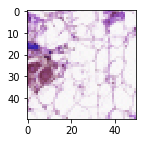

In [14]:
plt.figure(figsize=(2,2))
plt.imshow(X2[9])
print(Y2[9])

Splitting data, converting labels to one-hot vectors 

In [15]:
X=np.array(X,dtype=np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

Y_trainHot = to_categorical(Y_train)
Y_testHot = to_categorical(Y_test)


print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (81000, 50, 50, 3)
Testing Data Shape: (9000, 50, 50, 3)


plotting data imbalance

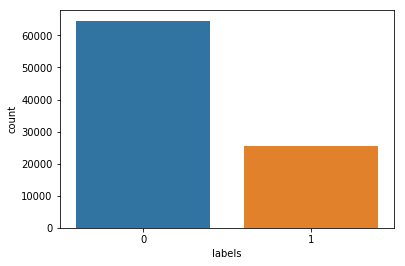

In [16]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)

importing ResNet50 model

In [17]:
rn = ResNet50(weights='imagenet', include_top=False,input_shape=(50,50,3))

C:\Users\harsh\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Preprocessing and predicting using resnet50

In [18]:
train_input = preprocess_input(X_train)
new_train = rn.predict(train_input)

In [21]:
test_input = preprocess_input(X_test)
new_test = rn.predict(test_input)

Fully Conncected model on top of Resnet50 using previously predicted weights

In [22]:
model = Sequential()


model.add(GlobalAveragePooling2D(input_shape=(new_train.shape[1:])))

model.add(Dense(2))
model.add(Activation('softmax'))

adam= Adam(lr=0.00001)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(new_train,Y_trainHot,batch_size=128,epochs = 100, validation_data=(new_test,Y_testHot))

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
81000/81000 [==============================] - 4s 45us/step - loss: 0.6823 - acc: 0.7016 - val_loss: 0.5745 - val_acc: 0.7490
Epoch 2/100
81000/81000 [==============================] - 3s 37us/step - loss: 0.5415 - acc: 0.7636 - val_loss: 0.5084 - val_acc: 0.7809
Epoch 3/100
81000/81000 [==============================] - 3s 39us/step - loss: 0.4948 - acc: 0.7855 - val_loss: 0.4764 - val_acc: 0.7948
Epoch 4/100
81000/81000 [==============================] - 3s 39us/step - loss: 0.4693 - acc: 0.7978 - val_loss: 0.4557 - val_acc: 0.8044
Epoch 5/100
81000/81000 [==============================] - 3s 39us/step - loss: 0.4520 - acc: 0.8055 - val_loss: 0.4410 - val_acc: 0.8107
Epoch 6/100
81000/81000 [==============================] - 3s 37us/step - loss: 0.4394 - acc: 0.8110 - val_loss: 0.4293 - val_acc: 0.8156
Epoch 7/100
81000/81000 [==============================] - 3s 38us/step - loss: 0.4295 - acc: 0.8155 - val_loss: 0.4203 - v

81000/81000 [==============================] - 3s 35us/step - loss: 0.3476 - acc: 0.8546 - val_loss: 0.3476 - val_acc: 0.8532
Epoch 60/100
81000/81000 [==============================] - 3s 35us/step - loss: 0.3473 - acc: 0.8549 - val_loss: 0.3475 - val_acc: 0.8524
Epoch 61/100
81000/81000 [==============================] - 3s 36us/step - loss: 0.3469 - acc: 0.8551 - val_loss: 0.3470 - val_acc: 0.8528
Epoch 62/100
81000/81000 [==============================] - 3s 36us/step - loss: 0.3466 - acc: 0.8555 - val_loss: 0.3470 - val_acc: 0.8532
Epoch 63/100
81000/81000 [==============================] - 3s 37us/step - loss: 0.3462 - acc: 0.8554 - val_loss: 0.3467 - val_acc: 0.8523
Epoch 64/100
81000/81000 [==============================] - 3s 36us/step - loss: 0.3459 - acc: 0.8553 - val_loss: 0.3469 - val_acc: 0.8518
Epoch 65/100
81000/81000 [==============================] - 3s 37us/step - loss: 0.3457 - acc: 0.8557 - val_loss: 0.3461 - val_acc: 0.8531
Epoch 66/100
81000/81000 [==============

Plotting Accuracy and loss

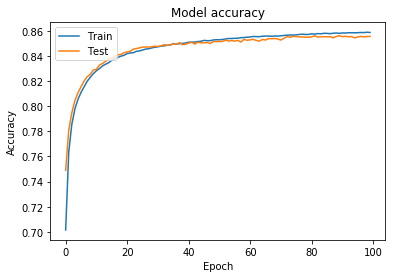

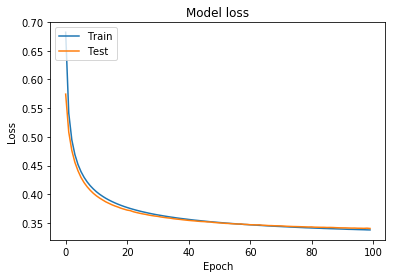

In [23]:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Solving data imbalances

X_trainRosReshaped Shape:  (45730, 50, 50, 3)
X_trainRosReshaped type:  float32
X_testRosReshaped Shape:  (5104, 50, 50, 3)


NameError: name 'dict_characters' is not defined

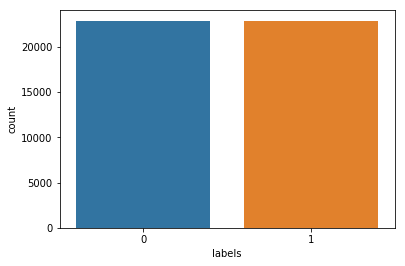

In [15]:
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

Y_trainRosHot = to_categorical(Y_trainRos)
Y_testRosHot = to_categorical(Y_testRos)

for i in range(len(X_trainRos)):
    height, width, channels = 50,50,3
    X_trainRosReshaped = X_trainRos.reshape(-1,50,50,3)

print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)
print("X_trainRosReshaped type: ",X_trainRosReshaped.dtype)

for i in range(len(X_testRos)):
    height, width, channels = 50,50,3
    X_testRosReshaped = X_testRos.reshape(-1,50,50,3)

print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

#plotting balanced data
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)

Using ResNet50 model to calculate accuracy and loss on new balanced data

In [16]:
rn = ResNet50(weights='imagenet', include_top=False,input_shape=(50,50,3))

C:\Users\harsh\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [18]:
train_input = preprocess_input(X_trainRosReshaped)
new_train = rn.predict(train_input)

In [19]:
test_input = preprocess_input(X_testRosReshaped)
new_test = rn.predict(test_input)

In [28]:
model = Sequential()


model.add(GlobalAveragePooling2D(input_shape=(new_train.shape[1:])))

model.add(Dense(2))
model.add(Activation('softmax'))

adam= Adam(lr=0.00001)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(new_train,Y_trainRosHot,batch_size=256,epochs = 100, validation_data=(new_test,Y_testRosHot))

Train on 45730 samples, validate on 5104 samples
Epoch 1/100
45730/45730 [==============================] - 2s 50us/step - loss: 1.6858 - acc: 0.4888 - val_loss: 1.2904 - val_acc: 0.4922
Epoch 2/100
45730/45730 [==============================] - 1s 31us/step - loss: 1.0780 - acc: 0.5243 - val_loss: 0.9502 - val_acc: 0.5594
Epoch 3/100
45730/45730 [==============================] - 1s 31us/step - loss: 0.8520 - acc: 0.5907 - val_loss: 0.8085 - val_acc: 0.6150
Epoch 4/100
45730/45730 [==============================] - 1s 31us/step - loss: 0.7460 - acc: 0.6401 - val_loss: 0.7345 - val_acc: 0.6491
Epoch 5/100
45730/45730 [==============================] - 1s 31us/step - loss: 0.6893 - acc: 0.6704 - val_loss: 0.6910 - val_acc: 0.6765
Epoch 6/100
45730/45730 [==============================] - 1s 31us/step - loss: 0.6554 - acc: 0.6896 - val_loss: 0.6626 - val_acc: 0.6946
Epoch 7/100
45730/45730 [==============================] - 1s 32us/step - loss: 0.6325 - acc: 0.7024 - val_loss: 0.6418 - v

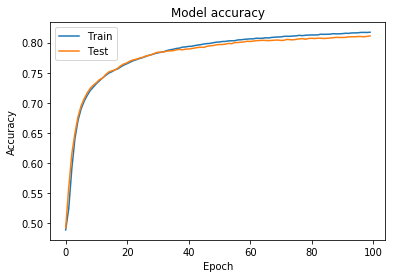

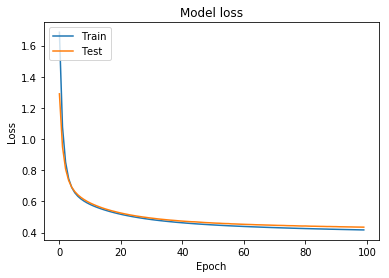

In [29]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()